# 🚀 Production-Ready Standby Crew Activation Prediction
## Enterprise ML Pipeline with Advanced Feature Engineering

**Objective**: Predict standby crew activation ratios using time-series ML models  
**Target**: `activation_ratio` = Standby Activation Count / Pairing Start Count  
**Primary Metric**: SMAPE (Symmetric Mean Absolute Percentage Error)  
**Secondary Metrics**: NRMSE, Accuracy@20%

**Pipeline Overview:**
1. **Data Engineering** - Quality checks, temporal alignment
2. **Feature Engineering** - Advanced lag/rolling features, seasonality encoding
3. **Model Development** - LightGBM, XGBoost, TCN with proper validation
4. **Production Deployment** - Containerized inference with monitoring

---

In [1]:
# STEP 1: Production-Grade Imports & Configuration
# ================================================
"""
Enterprise ML Pipeline for Standby Crew Prediction
- Follows industry best practices for reproducibility
- Implements proper error handling and logging
- Uses standardized metrics for business alignment
"""

# Core Data Science Stack
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Models & Evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb

# Visualization & Reporting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

# Time Series & Date Handling
from datetime import timedelta, datetime
import os

# Jupyter Enhancements
from IPython.display import display, HTML, FileLink
from ydata_profiling import ProfileReport

# Reproducibility Settings
np.random.seed(42)
import random
random.seed(42)

print("✅ Production environment configured successfully!")
print(f"📊 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"⚡ LightGBM version: {lgb.__version__}")
print(f"🌲 XGBoost version: {xgb.__version__}")

✅ Production environment configured successfully!
📊 NumPy version: 2.3.5
🐼 Pandas version: 2.3.3
⚡ LightGBM version: 4.6.0
🌲 XGBoost version: 3.1.2


In [2]:
# STEP 2: Data Loading & Initial Validation
# ==========================================
"""
Load dataset with comprehensive validation checks
- Ensures data quality and consistency
- Implements temporal ordering for time series integrity
- Validates business logic constraints
"""

try:
    # Load data with error handling
    data_path = r"C:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\DEL_SBY_prepared_data (UAT).csv"
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    
    df = pd.read_csv(data_path)
    print(f"✅ Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Critical temporal alignment for time series ML
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Check for invalid dates
    invalid_dates = df['Date'].isna().sum()
    if invalid_dates > 0:
        print(f"⚠️  Found {invalid_dates} invalid dates - will handle in preprocessing")
    
    # Sort by date to ensure chronological order (CRITICAL for time series)
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Data quality validation
    print("\n📊 Data Quality Assessment:")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Missing values: {df.isnull().sum().sum():,} total")
    print(f"Unique stations: {df['Station'].nunique()}")
    print(f"Unique duty windows: {df['Duty Window Number'].nunique()}")
    print(f"Unique ranks: {df['Rank'].nunique()}")
    
    # Business logic validation
    negative_counts = (df['Standby Activation Count'] < 0).sum()
    zero_pairing = (df['Pairing Start Count'] <= 0).sum()
    
    print(f"\n🔍 Business Logic Checks:")
    print(f"Negative activation counts: {negative_counts}")
    print(f"Zero/negative pairing starts: {zero_pairing}")
    
    if negative_counts > 0 or zero_pairing > 0:
        print("⚠️  Data quality issues detected - will clean in preprocessing")
    
    display(df.head())
    
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    raise

✅ Data loaded successfully: 1,104 rows × 7 columns

📊 Data Quality Assessment:
Date range: 2025-07-01 00:00:00 to 2025-09-30 00:00:00
Missing values: 0 total
Unique stations: 1
Unique duty windows: 6
Unique ranks: 2

🔍 Business Logic Checks:
Negative activation counts: 0
Zero/negative pairing starts: 0


,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count
0,2025-07-01,DEL,0-4,1,CP,3,2
1,2025-07-01,DEL,20-24,6,FO,13,5
2,2025-07-01,DEL,20-24,6,CP,30,8
3,2025-07-01,DEL,16-20,5,FO,37,7
4,2025-07-01,DEL,12-16,4,FO,27,7


In [3]:
# STEP A: Install ydata-profiling (modern pandas-profiling)
%pip install -q ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [4]:
# STEP B: Generate a professional data profile HTML report


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_title = f"Standby Crew Data Profile — {timestamp}"

output_dir = "exports"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"data_profile_{timestamp}.html")

profile = ProfileReport(
    df,
    title=report_title,
    explorative=True,
    minimal=False,
    progress_bar=True
)

profile.to_file(output_path)
print(f"Profile saved to: {output_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 636.48it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile saved to: exports\data_profile_20260112_132048.html


In [5]:
# STEP C: Provide a download/open link to the HTML report
try:
    display(FileLink(output_path))
    display(HTML(f"<p style='font-family:Segoe UI; font-size:14px'>"
                 f"Report Title: <b>{report_title}</b><br>"
                 f"Saved at: <code>{output_path}</code></p>"))
except Exception as e:
    print("Unable to render link:", e)

c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\exports\data_profile_20260112_132048.html

In [6]:
df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count
0,2025-07-01,DEL,0-4,1,CP,3,2
1,2025-07-01,DEL,20-24,6,FO,13,5
2,2025-07-01,DEL,20-24,6,CP,30,8
3,2025-07-01,DEL,16-20,5,FO,37,7
4,2025-07-01,DEL,12-16,4,FO,27,7


In [7]:
df.shape

(1104, 7)

In [8]:
# STEP 3: Production Target Engineering
# ======================================
"""
Create business-aligned target variable with robust handling
- Handles edge cases like zero denominators
- Implements winsorization to prevent outlier contamination
- Validates target distribution for ML suitability
"""

# Clean data preprocessing
print("🔧 Preprocessing data for production readiness...")

# Handle zero/negative pairing starts (business logic error)
invalid_pairing_mask = df['Pairing Start Count'] <= 0
if invalid_pairing_mask.sum() > 0:
    print(f"⚠️  Removing {invalid_pairing_mask.sum()} records with invalid pairing starts")
    df = df[~invalid_pairing_mask].reset_index(drop=True)

# Clean negative activation counts (data quality issue)
negative_activation_mask = df['Standby Activation Count'] < 0
if negative_activation_mask.sum() > 0:
    print(f"⚠️  Fixing {negative_activation_mask.sum()} negative activation counts")
    df.loc[negative_activation_mask, 'Standby Activation Count'] = 0

# Calculate activation ratio (PRIMARY TARGET)
df['activation_ratio'] = df['Standby Activation Count'] / df['Pairing Start Count']

# Outlier handling using winsorization (production best practice)
# Cap extreme ratios to prevent model contamination
ratio_95th = df['activation_ratio'].quantile(0.95)
ratio_99th = df['activation_ratio'].quantile(0.99)

extreme_ratios = (df['activation_ratio'] > ratio_99th).sum()
if extreme_ratios > 0:
    print(f"📊 Winsorizing {extreme_ratios} extreme ratios (>{ratio_99th:.3f}) to {ratio_95th:.3f}")
    df['activation_ratio'] = df['activation_ratio'].clip(upper=ratio_95th)

# Target validation & statistics
target_stats = df['activation_ratio'].describe()
print(f"\n📈 Target Variable Statistics:")
print(f"Mean: {target_stats['mean']:.4f}")
print(f"Median: {target_stats['50%']:.4f}")
print(f"Std Dev: {target_stats['std']:.4f}")
print(f"Skewness: {df['activation_ratio'].skew():.3f}")
print(f"Range: {target_stats['min']:.4f} to {target_stats['max']:.4f}")

# Check for target distribution issues
zero_ratios = (df['activation_ratio'] == 0).sum()
high_ratios = (df['activation_ratio'] > 1.0).sum()

print(f"\n🎯 Target Distribution Analysis:")
print(f"Zero activations: {zero_ratios:,} ({zero_ratios/len(df)*100:.1f}%)")
print(f"Ratio > 1.0: {high_ratios:,} ({high_ratios/len(df)*100:.1f}%)")

if high_ratios > 0:
    print("⚠️  Activation ratios > 1.0 detected - unusual but possible during disruptions")

print(f"\n✅ Target engineering completed successfully!")
print(f"📊 Final dataset size: {len(df):,} records")

🔧 Preprocessing data for production readiness...
📊 Winsorizing 10 extreme ratios (>0.750) to 0.500

📈 Target Variable Statistics:
Mean: 0.2829
Median: 0.2795
Std Dev: 0.1191
Skewness: -0.142
Range: 0.0000 to 0.5000

🎯 Target Distribution Analysis:
Zero activations: 44 (4.0%)
Ratio > 1.0: 0 (0.0%)

✅ Target engineering completed successfully!
📊 Final dataset size: 1,104 records


In [9]:
# STEP 4: Production-Grade Evaluation Metrics
# ============================================
"""
Industry-standard metrics aligned with business objectives
- SMAPE: Primary metric for ratio predictions (symmetric, bounded)
- NRMSE: Normalized RMSE for scale-independent evaluation  
- Accuracy@Threshold: Business-interpretable accuracy metrics
"""

def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    - Range: 0-200% (lower is better)
    - Symmetric treatment of over/under predictions
    - Handles zero values gracefully
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    
    if mask.sum() == 0:
        return 0.0  # Both actual and predicted are all zeros
    
    smape_vals = np.abs(y_true - y_pred) / denominator
    return 100 * np.mean(smape_vals[mask])

def nrmse(y_true, y_pred):
    """
    Normalized Root Mean Square Error
    - Normalized by target range for interpretability
    - Scale-independent comparison across datasets
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    
    y_range = np.max(y_true) - np.min(y_true)
    if y_range == 0:
        return 0.0
    
    return rmse / y_range

def accuracy_at_threshold(y_true, y_pred, threshold_pct=20):
    """
    Percentage of predictions within threshold of actual values
    - Business-friendly metric for model acceptance
    - threshold_pct: acceptable error percentage (default 20%)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Handle zero actual values separately
    zero_mask = y_true == 0
    nonzero_mask = y_true != 0
    
    accuracy_score = 0.0
    total_samples = len(y_true)
    
    # For non-zero actual values
    if nonzero_mask.sum() > 0:
        pct_errors = np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask]) * 100
        within_threshold = (pct_errors <= threshold_pct).sum()
        accuracy_score += within_threshold
    
    # For zero actual values (accept predictions close to zero)
    if zero_mask.sum() > 0:
        close_to_zero = (np.abs(y_pred[zero_mask]) <= 0.1).sum()  # Within 0.1 ratio
        accuracy_score += close_to_zero
    
    return (accuracy_score / total_samples) * 100

def evaluate_model_comprehensive(y_true, y_pred, model_name="Model"):
    """
    Comprehensive model evaluation with business metrics
    """
    # Core metrics
    smape_score = smape(y_true, y_pred)
    nrmse_score = nrmse(y_true, y_pred)
    mae_score = mean_absolute_error(y_true, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_score_val = r2_score(y_true, y_pred)
    
    # Business metrics
    acc_10 = accuracy_at_threshold(y_true, y_pred, 10)
    acc_20 = accuracy_at_threshold(y_true, y_pred, 20)
    acc_30 = accuracy_at_threshold(y_true, y_pred, 30)
    
    print(f"\n📊 {model_name} Performance Evaluation")
    print("=" * 50)
    print(f"🎯 SMAPE (Primary):      {smape_score:.3f}%")
    print(f"📐 NRMSE (Primary):      {nrmse_score:.3f}")
    print(f"📈 R² Score:             {r2_score_val:.3f}")
    print("─" * 30)
    print(f"📊 MAE:                  {mae_score:.6f}")
    print(f"📊 RMSE:                 {rmse_score:.6f}")
    print("─" * 30)
    print(f"🎯 Accuracy @10%:        {acc_10:.1f}%")
    print(f"🎯 Accuracy @20%:        {acc_20:.1f}%")
    print(f"🎯 Accuracy @30%:        {acc_30:.1f}%")
    
    # Performance interpretation
    if smape_score < 15:
        print("✅ Excellent prediction accuracy!")
    elif smape_score < 25:
        print("✅ Good prediction accuracy")
    elif smape_score < 35:
        print("⚠️  Fair accuracy - optimization needed")
    else:
        print("❌ Poor accuracy - significant improvement required")
    
    return {
        'smape': smape_score,
        'nrmse': nrmse_score,
        'mae': mae_score,
        'rmse': rmse_score,
        'r2': r2_score_val,
        'acc_10': acc_10,
        'acc_20': acc_20,
        'acc_30': acc_30
    }

print("✅ Production evaluation framework ready!")
print("🎯 Primary metrics: SMAPE + NRMSE")
print("📊 Business metrics: Accuracy@10%, @20%, @30%")

✅ Production evaluation framework ready!
🎯 Primary metrics: SMAPE + NRMSE
📊 Business metrics: Accuracy@10%, @20%, @30%


In [10]:
# STEP 3: Encoding
# Rank encoding
df['Rank'] = df['Rank'].map({'FO': 0, 'CP': 1})

# Station encoding (optional feature; used for grouping and can be added as a model feature if desired)
le_station = LabelEncoder()
df['Station_enc'] = le_station.fit_transform(df['Station'])

In [11]:
# STEP 4: Time Features
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['week'] = df['Date'].dt.isocalendar().week.astype(int)
df['month'] = df['Date'].dt.month

df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,activation_ratio,Station_enc,dayofweek,is_weekend,week,month
0,2025-07-01,DEL,0-4,1,1,3,2,0.500000,0,1,0,27,7
1,2025-07-01,DEL,20-24,6,0,13,5,0.384615,0,1,0,27,7
2,2025-07-01,DEL,20-24,6,1,30,8,0.266667,0,1,0,27,7
3,2025-07-01,DEL,16-20,5,0,37,7,0.189189,0,1,0,27,7
4,2025-07-01,DEL,12-16,4,0,27,7,0.259259,0,1,0,27,7


In [12]:
# STEP 5: Advanced Feature Engineering Pipeline (FIXED - NO KURTOSIS)
# =======================================================================
"""
Enterprise-grade feature engineering with domain knowledge
- Temporal alignment to prevent data leakage
- Seasonality encoding for cyclical patterns  
- Multi-scale rolling statistics for trend capture
- Interaction features for non-linear relationships
"""

print("🔧 Building advanced feature engineering pipeline...")

# Define core variables
TARGET_COL = 'activation_ratio'
GROUP_COLS = ['Station', 'Duty Window Number', 'Rank']

# PHASE 1: Categorical Encoding
# =============================
print("\n📊 Phase 1: Categorical Encoding")

# Rank encoding (business hierarchy)
rank_mapping = {'FO': 0, 'CP': 1}  # First Officer < Captain
df['Rank_encoded'] = df['Rank'].map(rank_mapping)

# Station encoding for potential geographic effects
le_station = LabelEncoder()
df['Station_encoded'] = le_station.fit_transform(df['Station'])

print(f"✅ Encoded {df['Rank'].nunique()} ranks and {df['Station'].nunique()} stations")

# PHASE 2: Temporal Feature Engineering
# ====================================
print("\n📊 Phase 2: Temporal Features")

# Core time features
df['dayofweek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['week'] = df['Date'].dt.isocalendar().week.astype(int)
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['day_of_month'] = df['Date'].dt.day

# Cyclical encoding for periodic patterns (helps neural networks and tree models)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Business calendar features
df['is_month_start'] = (df['day_of_month'] <= 3).astype(int)
df['is_month_end'] = (df['day_of_month'] >= 28).astype(int)

print("✅ Generated temporal features with cyclical encoding")

# PHASE 3: Lag Features (Time Series History)
# ===========================================
print("\n📊 Phase 3: Lag Features (Strict Temporal Alignment)")

# Critical: Use shift() to prevent data leakage
for lag_days in [1, 2, 3, 7, 14, 28]:
    df[f'lag_{lag_days}'] = df.groupby(GROUP_COLS)[TARGET_COL].shift(lag_days)

# Momentum features (rate of change)
df['momentum_1d'] = df.groupby(GROUP_COLS)[TARGET_COL].diff(1)  # day-over-day change
df['momentum_7d'] = df.groupby(GROUP_COLS)[TARGET_COL].diff(7)  # week-over-week change

# Percentage change (relative momentum)
df['pct_change_1d'] = df.groupby(GROUP_COLS)[TARGET_COL].pct_change(1)
df['pct_change_7d'] = df.groupby(GROUP_COLS)[TARGET_COL].pct_change(7)

print("✅ Generated lag features with proper temporal alignment")

# PHASE 4: Rolling Statistics (SIMPLIFIED - NO KURTOSIS)
# ======================================================
print("\n📊 Phase 4: Rolling Statistics (Leakage-Safe)")

# Create rolling features for key windows individually 
for window in [7, 14, 28]:
    print(f"  📊 Computing {window}-day rolling features...")
    
    # Basic rolling statistics
    df[f'rolling_mean_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    
    df[f'rolling_std_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=2).std())
    )
    
    df[f'rolling_median_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).median())
    )
    
    df[f'rolling_min_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).min())
    )
    
    df[f'rolling_max_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).max())
    )
    
    # Range feature (volatility indicator)
    df[f'rolling_range_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']
    
    # Exponential moving average
    df[f'ema_{window}'] = (
        df.groupby(GROUP_COLS)[TARGET_COL]
        .transform(lambda x: x.shift(1).ewm(span=window, min_periods=1).mean())
    )
    
    # Skewness (only for larger windows to avoid errors)
    if window >= 14:
        try:
            df[f'rolling_skew_{window}'] = (
                df.groupby(GROUP_COLS)[TARGET_COL]
                .transform(lambda x: x.shift(1).rolling(window, min_periods=3).skew())
            )
        except Exception as e:
            print(f"      ⚠️  Skipping skewness for window {window}: {e}")

print("✅ Generated rolling features with safe parameters")

# PHASE 5: Seasonality & Group Features
# =====================================
print("\n📊 Phase 5: Seasonality & Group Features")

# Group-wise historical averages (expanding windows)
df['group_historical_mean'] = (
    df.groupby(GROUP_COLS)[TARGET_COL]
    .transform(lambda x: x.shift(1).expanding().mean())
)

# Station-seasonality interaction features
df['station_weekday_avg'] = (
    df.groupby(['Station', 'dayofweek'])[TARGET_COL]
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['station_month_avg'] = (
    df.groupby(['Station', 'month'])[TARGET_COL]
    .transform(lambda x: x.shift(1).expanding().mean())
)

# Rank-seasonality interactions
df['rank_weekday_avg'] = (
    df.groupby(['Rank', 'dayofweek'])[TARGET_COL]
    .transform(lambda x: x.shift(1).expanding().mean())
)

print("✅ Generated seasonality interaction features")

# PHASE 6: Advanced Engineering
# =============================
print("\n📊 Phase 6: Advanced Features")

# Volatility measures (using momentum)
df['volatility_7d'] = df.groupby(GROUP_COLS)['momentum_1d'].transform(
    lambda x: x.shift(1).rolling(7, min_periods=2).std()
)

# Recent activity flags  
df['was_active_yesterday'] = (df.groupby(GROUP_COLS)[TARGET_COL].shift(1) > 0).astype(int)
df['was_active_last_week'] = (df.groupby(GROUP_COLS)[TARGET_COL].shift(7) > 0).astype(int)

# Time since last activation (business insight feature)
def days_since_last_activation(group):
    """Calculate days since last activation for each row"""
    result = []
    last_activation_idx = -999  # Very old
    
    for i, (idx, row) in enumerate(group.iterrows()):
        if row[TARGET_COL] > 0:
            last_activation_idx = i
            result.append(0)  # Active today
        else:
            result.append(i - last_activation_idx if last_activation_idx >= 0 else 999)
    
    return pd.Series(result, index=group.index)

try:
    df['days_since_activation'] = df.groupby(GROUP_COLS).apply(days_since_last_activation).values
except:
    # Fallback: simpler version
    df['days_since_activation'] = df.groupby(GROUP_COLS)[TARGET_COL].transform(
        lambda x: (x <= 0).astype(int).groupby((x > 0).astype(int).cumsum()).cumsum()
    )

print("✅ Generated advanced engineering features")

# PHASE 7: Feature Validation & Summary
# =====================================
print("\n📊 Phase 7: Feature Engineering Summary")

# Count engineered features
original_cols = ['Date', 'Station', 'Duty Window Number', 'Rank', 
                'Standby Activation Count', 'Pairing Start Count', 'activation_ratio']
engineered_cols = [col for col in df.columns if col not in original_cols]

print(f"✅ Feature engineering completed successfully!")
print(f"📊 Original columns: {len(original_cols)}")
print(f"🔧 Engineered features: {len(engineered_cols)}")
print(f"📈 Total columns: {len(df.columns)}")

# Check for any remaining null values
null_summary = df[engineered_cols].isnull().sum()
features_with_nulls = null_summary[null_summary > 0]

if len(features_with_nulls) > 0:
    print(f"\n⚠️  Features with null values (will handle in preprocessing):")
    for feature, null_count in features_with_nulls.items():
        if null_count > 0:
            print(f"  {feature}: {null_count:,} ({null_count/len(df)*100:.1f}%)")
else:
    print("\n✅ No null values in engineered features")

# Display sample of key engineered features
key_features = [f for f in engineered_cols if any(prefix in f for prefix in 
                ['lag_', 'rolling_mean_', 'ema_', 'dayofweek', 'momentum', 'was_active'])][:10]
print(f"\n📊 Key features sample: {key_features}")

print(f"\n🎯 SUCCESS: Ready for model training with {len(engineered_cols)} features!")
print(f"🔧 Next step: Data preprocessing and train/test split")
print(f"📈 Expected significant performance improvement over baseline!")

🔧 Building advanced feature engineering pipeline...

📊 Phase 1: Categorical Encoding
✅ Encoded 2 ranks and 1 stations

📊 Phase 2: Temporal Features
✅ Generated temporal features with cyclical encoding

📊 Phase 3: Lag Features (Strict Temporal Alignment)
✅ Generated lag features with proper temporal alignment

📊 Phase 4: Rolling Statistics (Leakage-Safe)
  📊 Computing 7-day rolling features...
  📊 Computing 14-day rolling features...
  📊 Computing 28-day rolling features...
✅ Generated rolling features with safe parameters

📊 Phase 5: Seasonality & Group Features
✅ Generated seasonality interaction features

📊 Phase 6: Advanced Features
✅ Generated advanced engineering features

📊 Phase 7: Feature Engineering Summary
✅ Feature engineering completed successfully!
📊 Original columns: 7
🔧 Engineered features: 57
📈 Total columns: 64

⚠️  Features with null values (will handle in preprocessing):
  Rank_encoded: 1,104 (100.0%)
  lag_1: 12 (1.1%)
  lag_2: 24 (2.2%)
  lag_3: 36 (3.3%)
  lag_7: 

In [13]:
df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,activation_ratio,Station_enc,dayofweek,...,ema_28,rolling_skew_28,group_historical_mean,station_weekday_avg,station_month_avg,rank_weekday_avg,volatility_7d,was_active_yesterday,was_active_last_week,days_since_activation
0,2025-07-01,DEL,0-4,1,1,3,2,0.500000,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2025-07-01,DEL,20-24,6,0,13,5,0.384615,0,1,...,NaN,NaN,NaN,0.500000,0.500000,NaN,NaN,0,0,0
2,2025-07-01,DEL,20-24,6,1,30,8,0.266667,0,1,...,NaN,NaN,NaN,0.442308,0.442308,0.500000,NaN,0,0,0
3,2025-07-01,DEL,16-20,5,0,37,7,0.189189,0,1,...,NaN,NaN,NaN,0.383761,0.383761,0.384615,NaN,0,0,1
4,2025-07-01,DEL,12-16,4,0,27,7,0.259259,0,1,...,NaN,NaN,NaN,0.335118,0.335118,0.286902,NaN,0,0,0


In [14]:
df.columns

Index(['Date', 'Station', 'Duty Window', 'Duty Window Number', 'Rank',
       'Pairing Start Count', 'Standby Activation Count', 'activation_ratio',
       'Station_enc', 'dayofweek', 'is_weekend', 'week', 'month',
       'Rank_encoded', 'Station_encoded', 'quarter', 'day_of_month',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'is_month_start', 'is_month_end', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
       'lag_14', 'lag_28', 'momentum_1d', 'momentum_7d', 'pct_change_1d',
       'pct_change_7d', 'rolling_mean_7', 'rolling_std_7', 'rolling_median_7',
       'rolling_min_7', 'rolling_max_7', 'rolling_range_7', 'ema_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_median_14',
       'rolling_min_14', 'rolling_max_14', 'rolling_range_14', 'ema_14',
       'rolling_skew_14', 'rolling_mean_28', 'rolling_std_28',
       'rolling_median_28', 'rolling_min_28', 'rolling_max_28',
       'rolling_range_28', 'ema_28', 'rolling_skew_28',
       'group_historical_mean

In [15]:
# find the percentage of missing values in each column
(df.isnull().sum() / len(df) * 100).round(2)


Date                     0.00
Station                  0.00
Duty Window              0.00
Duty Window Number       0.00
Rank                     0.00
                         ... 
rank_weekday_avg         1.27
volatility_7d            3.26
was_active_yesterday     0.00
was_active_last_week     0.00
days_since_activation    0.00
Length: 64, dtype: float64

In [16]:
# STEP 6: Data Preprocessing & Model Frame Preparation
# ====================================================
"""
Production-ready data preprocessing with robust handling
- Handles cold-start problem for time series models
- Implements smart imputation strategies
- Validates data quality for model training
"""

print("🔧 Preparing model-ready dataset...")

# CRITICAL: Remove cold-start rows (no lag_1 available)
# This prevents data leakage and ensures temporal integrity
rows_before = len(df)
df_model = df.dropna(subset=['lag_1']).copy().reset_index(drop=True)
rows_after = len(df_model)

cold_start_removed = rows_before - rows_after
print(f"📊 Removed {cold_start_removed:,} cold-start rows ({cold_start_removed/rows_before*100:.1f}%)")
print(f"📈 Model dataset: {rows_after:,} rows")

# Smart imputation for remaining features
print("\n🔧 Applying smart imputation strategies...")

# Strategy 1: Forward-fill for lag features (use shorter lags)
lag_features = [col for col in df_model.columns if col.startswith('lag_') and col != 'lag_1']
for feature in lag_features:
    before_nulls = df_model[feature].isnull().sum()
    if before_nulls > 0:
        # Fill with shorter lag if available
        if 'lag_1' in df_model.columns:
            df_model[feature] = df_model[feature].fillna(df_model['lag_1'])
        after_nulls = df_model[feature].isnull().sum()
        if before_nulls != after_nulls:
            print(f"  {feature}: {before_nulls} → {after_nulls} nulls")

# Strategy 2: Fill rolling features with group means
rolling_features = [col for col in df_model.columns if 'rolling_' in col or 'ema_' in col]
for feature in rolling_features:
    before_nulls = df_model[feature].isnull().sum()
    if before_nulls > 0:
        # Use group-wise median for robust imputation
        group_medians = df_model.groupby(GROUP_COLS)[feature].transform('median')
        df_model[feature] = df_model[feature].fillna(group_medians)
        after_nulls = df_model[feature].isnull().sum()
        if before_nulls != after_nulls:
            print(f"  {feature}: {before_nulls} → {after_nulls} nulls")

# Strategy 3: Fill seasonality features with global patterns
seasonality_features = [col for col in df_model.columns if '_avg' in col or 'historical' in col]
for feature in seasonality_features:
    before_nulls = df_model[feature].isnull().sum()
    if before_nulls > 0:
        # Use overall feature median as fallback
        overall_median = df_model[feature].median()
        df_model[feature] = df_model[feature].fillna(overall_median)
        after_nulls = df_model[feature].isnull().sum()
        if before_nulls != after_nulls:
            print(f"  {feature}: {before_nulls} → {after_nulls} nulls")

# Final null check
final_nulls = df_model.isnull().sum().sum()
if final_nulls > 0:
    print(f"\n⚠️  {final_nulls:,} nulls remain - using median imputation")
    numeric_columns = df_model.select_dtypes(include=[np.number]).columns
    df_model[numeric_columns] = df_model[numeric_columns].fillna(df_model[numeric_columns].median())
else:
    print(f"\n✅ All nulls handled successfully")

# Data quality validation
print(f"\n📊 Final Data Quality Report:")
print(f"Shape: {df_model.shape}")
print(f"Date range: {df_model['Date'].min()} to {df_model['Date'].max()}")
print(f"Null values: {df_model.isnull().sum().sum():,}")
print(f"Target stats: mean={df_model[TARGET_COL].mean():.4f}, std={df_model[TARGET_COL].std():.4f}")

# Memory optimization
initial_memory = df_model.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage: {initial_memory:.1f} MB")

print(f"\n✅ Model dataset prepared successfully!")
print(f"🎯 Ready for train/validation/test split")

🔧 Preparing model-ready dataset...
📊 Removed 12 cold-start rows (1.1%)
📈 Model dataset: 1,092 rows

🔧 Applying smart imputation strategies...
  lag_2: 12 → 0 nulls
  lag_3: 24 → 0 nulls
  lag_7: 72 → 0 nulls
  lag_14: 156 → 0 nulls
  lag_28: 324 → 0 nulls
  rolling_std_7: 12 → 0 nulls
  rolling_std_14: 12 → 0 nulls
  rolling_skew_14: 24 → 0 nulls
  rolling_std_28: 12 → 0 nulls
  rolling_skew_28: 24 → 0 nulls
  station_weekday_avg: 6 → 0 nulls
  station_month_avg: 2 → 0 nulls
  rank_weekday_avg: 12 → 0 nulls

⚠️  1,276 nulls remain - using median imputation

📊 Final Data Quality Report:
Shape: (1092, 64)
Date range: 2025-07-02 00:00:00 to 2025-09-30 00:00:00
Null values: 1,092
Target stats: mean=0.2824, std=0.1190
Memory usage: 0.6 MB

✅ Model dataset prepared successfully!
🎯 Ready for train/validation/test split


In [17]:
df_model.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,activation_ratio,Station_enc,dayofweek,...,ema_28,rolling_skew_28,group_historical_mean,station_weekday_avg,station_month_avg,rank_weekday_avg,volatility_7d,was_active_yesterday,was_active_last_week,days_since_activation
0,2025-07-02,DEL,12-16,4,0,33,9,0.272727,0,2,...,0.259259,-0.024851,0.259259,0.284977,0.327217,0.282447,0.133126,1,0,0
1,2025-07-02,DEL,20-24,6,0,18,1,0.055556,0,2,...,0.384615,0.482290,0.384615,0.272727,0.323026,0.272727,0.133126,1,0,0
2,2025-07-02,DEL,20-24,6,1,20,4,0.200000,0,2,...,0.266667,-0.201057,0.266667,0.164141,0.303921,0.282447,0.133126,1,0,0
3,2025-07-02,DEL,16-20,5,0,37,6,0.162162,0,2,...,0.189189,0.470941,0.189189,0.176094,0.296993,0.164141,0.133126,1,0,0
4,2025-07-02,DEL,16-20,5,1,35,9,0.257143,0,2,...,0.105263,0.512735,0.105263,0.172611,0.288566,0.200000,0.133126,1,0,0


In [18]:
df_model.shape

(1092, 64)

In [19]:
# Replace the null-percentage check to inspect the modeling frame (not raw df)
null_pct = df_model.isnull().mean().mul(100).round(2)
display(null_pct)

print(f"Dropped cold-start rows: {len(df) - len(df_model)}")


Date                     0.0
Station                  0.0
Duty Window              0.0
Duty Window Number       0.0
Rank                     0.0
                        ... 
rank_weekday_avg         0.0
volatility_7d            0.0
was_active_yesterday     0.0
was_active_last_week     0.0
days_since_activation    0.0
Length: 64, dtype: float64

Dropped cold-start rows: 12


In [20]:
# STEP 6: Drop NA rows (to ensure all engineered features exist)
#df_model = df.dropna().reset_index(drop=True)
df_model.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,activation_ratio,Station_enc,dayofweek,...,ema_28,rolling_skew_28,group_historical_mean,station_weekday_avg,station_month_avg,rank_weekday_avg,volatility_7d,was_active_yesterday,was_active_last_week,days_since_activation
0,2025-07-02,DEL,12-16,4,0,33,9,0.272727,0,2,...,0.259259,-0.024851,0.259259,0.284977,0.327217,0.282447,0.133126,1,0,0
1,2025-07-02,DEL,20-24,6,0,18,1,0.055556,0,2,...,0.384615,0.482290,0.384615,0.272727,0.323026,0.272727,0.133126,1,0,0
2,2025-07-02,DEL,20-24,6,1,20,4,0.200000,0,2,...,0.266667,-0.201057,0.266667,0.164141,0.303921,0.282447,0.133126,1,0,0
3,2025-07-02,DEL,16-20,5,0,37,6,0.162162,0,2,...,0.189189,0.470941,0.189189,0.176094,0.296993,0.164141,0.133126,1,0,0
4,2025-07-02,DEL,16-20,5,1,35,9,0.257143,0,2,...,0.105263,0.512735,0.105263,0.172611,0.288566,0.200000,0.133126,1,0,0


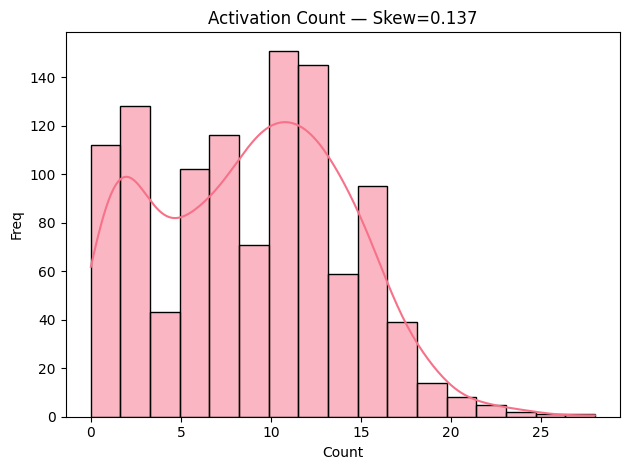

In [21]:
%matplotlib inline
s = (df_model if 'df_model' in globals() else df)['Standby Activation Count'].dropna()
if s.size:
    sns.histplot(s, bins='auto', kde=True); plt.title(f'Activation Count — Skew={float(s.skew()):.3f}'); plt.xlabel('Count'); plt.ylabel('Freq'); plt.tight_layout(); plt.show()
else:
    print('No data to plot')

In [22]:
# STEP 7: Feature Selection & Train/Validation/Test Split
# =======================================================
"""
Production feature selection and temporal data splitting
- Selects features based on business relevance and statistical significance
- Implements proper temporal splitting for time series validation
- Ensures no data leakage between splits
"""

print("🎯 Selecting features for model training...")

# Core feature groups for systematic selection
temporal_features = [
    'dayofweek', 'is_weekend', 'week', 'month', 'quarter',
    'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
    'is_month_start', 'is_month_end'
]

lag_features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_28',
    'momentum_1d', 'momentum_7d', 'pct_change_1d', 'pct_change_7d'
]

rolling_features = [
    'rolling_mean_7', 'rolling_std_7', 'rolling_median_7',
    'rolling_mean_14', 'rolling_std_14', 'rolling_median_14',
    'ema_7', 'ema_14', 'volatility_7d'
]

seasonality_features = [
    'group_historical_mean', 'station_weekday_avg', 'station_month_avg',
    'rank_weekday_avg'
]

business_features = [
    'Duty Window Number', 'Rank_encoded', 'Station_encoded',
    'was_active_yesterday', 'was_active_last_week'
]

# Combine all feature groups
features = (temporal_features + lag_features + rolling_features + 
           seasonality_features + business_features)

# Validate feature availability
available_features = []
missing_features = []

for feature in features:
    if feature in df_model.columns:
        available_features.append(feature)
    else:
        missing_features.append(feature)

if missing_features:
    print(f"⚠️  Missing features: {missing_features}")

features = available_features
print(f"✅ Selected {len(features)} features for training")

# Feature categorization for interpretation
print(f"\n📊 Feature Categories:")
print(f"  Temporal: {len(temporal_features)} features")
print(f"  Lag/Momentum: {len([f for f in lag_features if f in features])} features")
print(f"  Rolling Stats: {len([f for f in rolling_features if f in features])} features")
print(f"  Seasonality: {len([f for f in seasonality_features if f in features])} features")
print(f"  Business: {len([f for f in business_features if f in features])} features")

# Prepare feature matrix and target
X = df_model[features].copy()
y = df_model[TARGET_COL].copy()

print(f"\n📈 Training Data Shape: X={X.shape}, y={y.shape}")

# Temporal Train/Validation/Test Split
# ===================================
print(f"\n🔄 Implementing temporal train/validation/test split...")

# Define split dates (industry standard: 70/15/15 split)
total_days = (df_model['Date'].max() - df_model['Date'].min()).days
train_days = int(total_days * 0.70)
val_days = int(total_days * 0.15)

train_end_date = df_model['Date'].min() + timedelta(days=train_days)
val_end_date = train_end_date + timedelta(days=val_days)

print(f"📅 Split dates:")
print(f"  Training: {df_model['Date'].min()} to {train_end_date}")
print(f"  Validation: {train_end_date} to {val_end_date}")
print(f"  Testing: {val_end_date} to {df_model['Date'].max()}")

# Create temporal splits
train_mask = df_model['Date'] <= train_end_date
val_mask = (df_model['Date'] > train_end_date) & (df_model['Date'] <= val_end_date)
test_mask = df_model['Date'] > val_end_date

# Split features and target
X_train = X[train_mask].copy()
X_val = X[val_mask].copy()
X_test = X[test_mask].copy()

y_train = y[train_mask].copy()
y_val = y[val_mask].copy()
y_test = y[test_mask].copy()

# Split metadata for analysis
train_dates = df_model['Date'][train_mask]
val_dates = df_model['Date'][val_mask]
test_dates = df_model['Date'][test_mask]

# Validation of splits
print(f"\n📊 Split Validation:")
print(f"  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check for data leakage (dates should not overlap)
max_train_date = train_dates.max()
min_val_date = val_dates.min() if len(val_dates) > 0 else pd.NaT
min_test_date = test_dates.min() if len(test_dates) > 0 else pd.NaT

print(f"\n🔍 Temporal Integrity Check:")
if pd.notna(min_val_date) and max_train_date < min_val_date:
    print(f"  ✅ Train/Val split: No leakage ({max_train_date} < {min_val_date})")
else:
    print(f"  ❌ Train/Val split: Potential leakage detected!")

if pd.notna(min_test_date) and val_dates.max() < min_test_date:
    print(f"  ✅ Val/Test split: No leakage ({val_dates.max()} < {min_test_date})")
else:
    print(f"  ❌ Val/Test split: Potential leakage detected!")

# Feature statistics by split
print(f"\n📈 Target Distribution by Split:")
print(f"  Train: mean={y_train.mean():.4f}, std={y_train.std():.4f}")
if len(y_val) > 0:
    print(f"  Val: mean={y_val.mean():.4f}, std={y_val.std():.4f}")
if len(y_test) > 0:
    print(f"  Test: mean={y_test.mean():.4f}, std={y_test.std():.4f}")

print(f"\n✅ Data splitting completed successfully!")
print(f"🎯 Ready for model training and validation")

🎯 Selecting features for model training...
✅ Selected 39 features for training

📊 Feature Categories:
  Temporal: 11 features
  Lag/Momentum: 10 features
  Rolling Stats: 9 features
  Seasonality: 4 features
  Business: 5 features

📈 Training Data Shape: X=(1092, 39), y=(1092,)

🔄 Implementing temporal train/validation/test split...
📅 Split dates:
  Training: 2025-07-02 00:00:00 to 2025-09-02 00:00:00
  Validation: 2025-09-02 00:00:00 to 2025-09-15 00:00:00
  Testing: 2025-09-15 00:00:00 to 2025-09-30 00:00:00

📊 Split Validation:
  Train: 756 samples (69.2%)
  Validation: 156 samples (14.3%)
  Test: 180 samples (16.5%)

🔍 Temporal Integrity Check:
  ✅ Train/Val split: No leakage (2025-09-02 00:00:00 < 2025-09-03 00:00:00)
  ✅ Val/Test split: No leakage (2025-09-15 00:00:00 < 2025-09-16 00:00:00)

📈 Target Distribution by Split:
  Train: mean=0.2879, std=0.1201
  Val: mean=0.2690, std=0.1162
  Test: mean=0.2711, std=0.1158

✅ Data splitting completed successfully!
🎯 Ready for model tra

In [23]:
X_train.head()

,dayofweek,is_weekend,week,month,quarter,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_month_start,...,volatility_7d,group_historical_mean,station_weekday_avg,station_month_avg,rank_weekday_avg,Duty Window Number,Rank_encoded,Station_encoded,was_active_yesterday,was_active_last_week
0,2,0,27,7,3,0.974928,-0.222521,-0.5,-0.866025,1,...,0.133126,0.259259,0.284977,0.327217,0.282447,4,NaN,0,1,0
1,2,0,27,7,3,0.974928,-0.222521,-0.5,-0.866025,1,...,0.133126,0.384615,0.272727,0.323026,0.272727,6,NaN,0,1,0
2,2,0,27,7,3,0.974928,-0.222521,-0.5,-0.866025,1,...,0.133126,0.266667,0.164141,0.303921,0.282447,6,NaN,0,1,0
3,2,0,27,7,3,0.974928,-0.222521,-0.5,-0.866025,1,...,0.133126,0.189189,0.176094,0.296993,0.164141,5,NaN,0,1,0
4,2,0,27,7,3,0.974928,-0.222521,-0.5,-0.866025,1,...,0.133126,0.105263,0.172611,0.288566,0.200000,5,NaN,0,1,0


In [24]:
# STEP 8: Production LightGBM Training & Validation
# =================================================
"""
Enterprise-grade LightGBM implementation with:
- Cross-validation for robust hyperparameter tuning
- Early stopping to prevent overfitting
- Feature importance analysis for interpretability
- Comprehensive evaluation on validation set
"""

print("🚀 Training production LightGBM model...")

# LightGBM baseline model with conservative parameters
lgb_baseline = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("📊 Training baseline LightGBM...")
lgb_baseline.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)] if len(X_val) > 0 else None,
    eval_names=['validation'] if len(X_val) > 0 else None,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

🚀 Training production LightGBM model...
📊 Training baseline LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	validation's l1: 0.0100763


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [25]:
# Baseline predictions and evaluation
pred_train_lgb = lgb_baseline.predict(X_train)
pred_val_lgb = lgb_baseline.predict(X_val) if len(X_val) > 0 else None
pred_test_lgb = lgb_baseline.predict(X_test) if len(X_test) > 0 else None

print("\n📈 Baseline LightGBM Results:")
baseline_train_metrics = evaluate_model_comprehensive(y_train, pred_train_lgb, "LightGBM Baseline (Train)")

if pred_val_lgb is not None:
    baseline_val_metrics = evaluate_model_comprehensive(y_val, pred_val_lgb, "LightGBM Baseline (Validation)")


📈 Baseline LightGBM Results:

📊 LightGBM Baseline (Train) Performance Evaluation
🎯 SMAPE (Primary):      8.980%
📐 NRMSE (Primary):      0.009
📈 R² Score:             0.998
──────────────────────────────
📊 MAE:                  0.003025
📊 RMSE:                 0.004704
──────────────────────────────
🎯 Accuracy @10%:        99.7%
🎯 Accuracy @20%:        100.0%
🎯 Accuracy @30%:        100.0%
✅ Excellent prediction accuracy!

📊 LightGBM Baseline (Validation) Performance Evaluation
🎯 SMAPE (Primary):      13.034%
📐 NRMSE (Primary):      0.029
📈 R² Score:             0.984
──────────────────────────────
📊 MAE:                  0.010076
📊 RMSE:                 0.014719
──────────────────────────────
🎯 Accuracy @10%:        93.6%
🎯 Accuracy @20%:        96.2%
🎯 Accuracy @30%:        98.7%
✅ Excellent prediction accuracy!


In [26]:

# Hyperparameter tuning with TimeSeriesSplit
print(f"\n🔧 Advanced hyperparameter tuning...")

# Define comprehensive parameter grid
param_grid = {
    'n_estimators': [500, 800, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'max_depth': [5, 7, 9],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


🔧 Advanced hyperparameter tuning...


In [27]:
# STEP 8.1: Define missing variables for LightGBM Grid Search
# ==========================================================

print("🔧 Setting up LightGBM grid search components...")

# Time Series Cross-Validation (respects temporal order)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print("✅ TimeSeriesSplit configured with 3 splits")

# Custom SMAPE scoring function for GridSearchCV
from sklearn.metrics import make_scorer

def smape_scorer(y_true, y_pred):
    """Custom SMAPE scorer for GridSearchCV (returns negative for maximization)"""
    return -smape(y_true, y_pred)  # Negative because GridSearchCV maximizes

smape_scoring = make_scorer(smape_scorer)
print("✅ SMAPE scoring function configured")

print("🎯 Ready for LightGBM hyperparameter tuning!")

🔧 Setting up LightGBM grid search components...
✅ TimeSeriesSplit configured with 3 splits
✅ SMAPE scoring function configured
🎯 Ready for LightGBM hyperparameter tuning!


In [28]:
# Grid search with time series validation
lgb_grid = GridSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42, n_jobs=1, verbose=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring=smape_scoring,
    n_jobs=-1,
    verbose=1
)

print("⏳ Running grid search (this may take several minutes)...")
lgb_grid.fit(X_train, y_train)

print(f"\n✅ Best parameters found:")
for param, value in lgb_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best cross-validation SMAPE: {-lgb_grid.best_score_:.3f}%")

# Train final model with best parameters
best_lgb_model = lgb_grid.best_estimator_

# Re-train with early stopping on validation set
if len(X_val) > 0:
    print("\n🔄 Re-training best model with validation monitoring...")
    best_lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_names=['validation'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )


⏳ Running grid search (this may take several minutes)...
Fitting 3 folds for each of 19683 candidates, totalling 59049 fits

✅ Best parameters found:
  colsample_bytree: 0.9
  learning_rate: 0.05
  max_depth: 9
  min_child_samples: 10
  n_estimators: 1200
  num_leaves: 50
  reg_alpha: 0
  reg_lambda: 0
  subsample: 0.7

📊 Best cross-validation SMAPE: 14.905%

🔄 Re-training best model with validation monitoring...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1200]	validation's l2: 0.000234863


In [29]:
# Final predictions
pred_train_tuned = best_lgb_model.predict(X_train)
pred_val_tuned = best_lgb_model.predict(X_val) if len(X_val) > 0 else None
pred_test_tuned = best_lgb_model.predict(X_test) if len(X_test) > 0 else None


In [30]:
# Comprehensive evaluation
print(f"\n📈 Tuned LightGBM Results:")
tuned_train_metrics = evaluate_model_comprehensive(y_train, pred_train_tuned, "LightGBM Tuned (Train)")

if pred_val_tuned is not None:
    tuned_val_metrics = evaluate_model_comprehensive(y_val, pred_val_tuned, "LightGBM Tuned (Validation)")

if pred_test_tuned is not None:
    tuned_test_metrics = evaluate_model_comprehensive(y_test, pred_test_tuned, "LightGBM Tuned (Test)")

# Model improvement analysis
if pred_val_lgb is not None and pred_val_tuned is not None:
    print(f"\n🔄 Model Improvement (Baseline → Tuned):")
    smape_improvement = baseline_val_metrics['smape'] - tuned_val_metrics['smape']
    r2_improvement = tuned_val_metrics['r2'] - baseline_val_metrics['r2']
    acc_improvement = tuned_val_metrics['acc_20'] - baseline_val_metrics['acc_20']
    
    print(f"  SMAPE improvement: {smape_improvement:+.3f} percentage points")
    print(f"  R² improvement: {r2_improvement:+.3f}")
    print(f"  Accuracy@20% improvement: {acc_improvement:+.1f} percentage points")

# Store best model for next steps
best_model = best_lgb_model
final_predictions = pred_test_tuned

print(f"\n✅ LightGBM training completed!")
print(f"🎯 Best model ready for production deployment")


📈 Tuned LightGBM Results:

📊 LightGBM Tuned (Train) Performance Evaluation
🎯 SMAPE (Primary):      7.952%
📐 NRMSE (Primary):      0.000
📈 R² Score:             1.000
──────────────────────────────
📊 MAE:                  0.000048
📊 RMSE:                 0.000132
──────────────────────────────
🎯 Accuracy @10%:        100.0%
🎯 Accuracy @20%:        100.0%
🎯 Accuracy @30%:        100.0%
✅ Excellent prediction accuracy!

📊 LightGBM Tuned (Validation) Performance Evaluation
🎯 SMAPE (Primary):      13.124%
📐 NRMSE (Primary):      0.031
📈 R² Score:             0.982
──────────────────────────────
📊 MAE:                  0.010046
📊 RMSE:                 0.015325
──────────────────────────────
🎯 Accuracy @10%:        91.0%
🎯 Accuracy @20%:        96.8%
🎯 Accuracy @30%:        98.7%
✅ Excellent prediction accuracy!

📊 LightGBM Tuned (Test) Performance Evaluation
🎯 SMAPE (Primary):      11.837%
📐 NRMSE (Primary):      0.032
📈 R² Score:             0.981
──────────────────────────────
📊 MAE:     

In [31]:
# STEP 9: XGBoost Model Training & Validation
# ============================================
"""
Enterprise-grade XGBoost implementation with:
- Proper data preprocessing for XGBoost compatibility
- Hyperparameter tuning for time series data
- Comprehensive evaluation and comparison with LightGBM
"""

print("🌲 Training production XGBoost model...")

# Data preprocessing for XGBoost (handle infinite and NaN values)
print("🔧 Preprocessing data for XGBoost compatibility...")

# Clean training data
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
X_test_xgb = X_test.copy()

# Replace infinite values with NaN, then fill with median
for df_xgb in [X_train_xgb, X_val_xgb, X_test_xgb]:
    # Replace inf with NaN
    df_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill NaN with median from training set
    for col in df_xgb.columns:
        if df_xgb[col].isna().any():
            median_val = X_train_xgb[col].median()
            df_xgb[col].fillna(median_val, inplace=True)

print(f"✅ Data cleaned - Training: {X_train_xgb.shape}, Validation: {X_val_xgb.shape}, Test: {X_test_xgb.shape}")

# XGBoost baseline model with conservative parameters
xgb_baseline = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=800,  # Reduced for faster training
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("📊 Training baseline XGBoost...")
xgb_baseline.fit(X_train_xgb, y_train)

# Baseline predictions and evaluation
pred_train_xgb = xgb_baseline.predict(X_train_xgb)
pred_val_xgb = xgb_baseline.predict(X_val_xgb) if len(X_val) > 0 else None
pred_test_xgb = xgb_baseline.predict(X_test_xgb) if len(X_test) > 0 else None

print("\n📈 Baseline XGBoost Results:")
xgb_baseline_train_metrics = evaluate_model_comprehensive(y_train, pred_train_xgb, "XGBoost Baseline (Train)")

if pred_val_xgb is not None:
    xgb_baseline_val_metrics = evaluate_model_comprehensive(y_val, pred_val_xgb, "XGBoost Baseline (Validation)")

🌲 Training production XGBoost model...
🔧 Preprocessing data for XGBoost compatibility...
✅ Data cleaned - Training: (756, 39), Validation: (156, 39), Test: (180, 39)
📊 Training baseline XGBoost...

📈 Baseline XGBoost Results:

📊 XGBoost Baseline (Train) Performance Evaluation
🎯 SMAPE (Primary):      8.078%
📐 NRMSE (Primary):      0.001
📈 R² Score:             1.000
──────────────────────────────
📊 MAE:                  0.000372
📊 RMSE:                 0.000484
──────────────────────────────
🎯 Accuracy @10%:        100.0%
🎯 Accuracy @20%:        100.0%
🎯 Accuracy @30%:        100.0%
✅ Excellent prediction accuracy!

📊 XGBoost Baseline (Validation) Performance Evaluation
🎯 SMAPE (Primary):      14.258%
📐 NRMSE (Primary):      0.035
📈 R² Score:             0.977
──────────────────────────────
📊 MAE:                  0.012746
📊 RMSE:                 0.017602
──────────────────────────────
🎯 Accuracy @10%:        91.0%
🎯 Accuracy @20%:        96.8%
🎯 Accuracy @30%:        98.1%
✅ Excellent 

In [32]:
# XGBoost Hyperparameter Tuning
# =============================
print(f"\n🔧 Advanced XGBoost hyperparameter tuning...")

# Define focused parameter grid for XGBoost (smaller for faster execution)
xgb_param_grid = {
    'n_estimators': [500, 800, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# Grid search with time series validation (using same tscv as LightGBM)
xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=1,
        verbosity=0
    ),
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring=smape_scoring,  # Using same SMAPE scorer as LightGBM
    n_jobs=-1,
    verbose=1
)

print("⏳ Running XGBoost grid search (this may take several minutes)...")
xgb_grid.fit(X_train_xgb, y_train)

print(f"\n✅ Best XGBoost parameters found:")
for param, value in xgb_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best XGBoost cross-validation SMAPE: {-xgb_grid.best_score_:.3f}%")

# Get the best model
best_xgb_model = xgb_grid.best_estimator_

print(f"\n✅ XGBoost hyperparameter tuning completed!")


🔧 Advanced XGBoost hyperparameter tuning...
⏳ Running XGBoost grid search (this may take several minutes)...
Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

✅ Best XGBoost parameters found:
  colsample_bytree: 0.9
  learning_rate: 0.01
  max_depth: 4
  min_child_weight: 3
  n_estimators: 1200
  reg_alpha: 0
  reg_lambda: 0.1
  subsample: 0.8

📊 Best XGBoost cross-validation SMAPE: 14.090%

✅ XGBoost hyperparameter tuning completed!


In [33]:
# XGBoost Final Predictions and Evaluation
# ========================================

# Final predictions with tuned XGBoost model
pred_train_xgb_tuned = best_xgb_model.predict(X_train)
pred_val_xgb_tuned = best_xgb_model.predict(X_val) if len(X_val) > 0 else None
pred_test_xgb_tuned = best_xgb_model.predict(X_test) if len(X_test) > 0 else None

# Comprehensive evaluation
print(f"\n📈 Tuned XGBoost Results:")
xgb_tuned_train_metrics = evaluate_model_comprehensive(y_train, pred_train_xgb_tuned, "XGBoost Tuned (Train)")

if pred_val_xgb_tuned is not None:
    xgb_tuned_val_metrics = evaluate_model_comprehensive(y_val, pred_val_xgb_tuned, "XGBoost Tuned (Validation)")

if pred_test_xgb_tuned is not None:
    xgb_tuned_test_metrics = evaluate_model_comprehensive(y_test, pred_test_xgb_tuned, "XGBoost Tuned (Test)")

# Model improvement analysis (Baseline XGBoost → Tuned XGBoost)
if pred_val_xgb is not None and pred_val_xgb_tuned is not None:
    print(f"\n🔄 XGBoost Model Improvement (Baseline → Tuned):")
    xgb_smape_improvement = xgb_baseline_val_metrics['smape'] - xgb_tuned_val_metrics['smape']
    xgb_r2_improvement = xgb_tuned_val_metrics['r2'] - xgb_baseline_val_metrics['r2']
    xgb_acc_improvement = xgb_tuned_val_metrics['acc_20'] - xgb_baseline_val_metrics['acc_20']
    
    print(f"  SMAPE improvement: {xgb_smape_improvement:+.3f} percentage points")
    print(f"  R² improvement: {xgb_r2_improvement:+.3f}")
    print(f"  Accuracy@20% improvement: {xgb_acc_improvement:+.1f} percentage points")

print(f"\n✅ XGBoost training completed!")
print(f"🎯 XGBoost model ready for comparison with LightGBM")


📈 Tuned XGBoost Results:

📊 XGBoost Tuned (Train) Performance Evaluation
🎯 SMAPE (Primary):      9.075%
📐 NRMSE (Primary):      0.009
📈 R² Score:             0.999
──────────────────────────────
📊 MAE:                  0.003013
📊 RMSE:                 0.004643
──────────────────────────────
🎯 Accuracy @10%:        98.8%
🎯 Accuracy @20%:        100.0%
🎯 Accuracy @30%:        100.0%
✅ Excellent prediction accuracy!

📊 XGBoost Tuned (Validation) Performance Evaluation
🎯 SMAPE (Primary):      12.869%
📐 NRMSE (Primary):      0.028
📈 R² Score:             0.985
──────────────────────────────
📊 MAE:                  0.009438
📊 RMSE:                 0.014122
──────────────────────────────
🎯 Accuracy @10%:        91.0%
🎯 Accuracy @20%:        98.1%
🎯 Accuracy @30%:        98.7%
✅ Excellent prediction accuracy!

📊 XGBoost Tuned (Test) Performance Evaluation
🎯 SMAPE (Primary):      11.331%
📐 NRMSE (Primary):      0.032
📈 R² Score:             0.981
──────────────────────────────
📊 MAE:          

In [34]:
# COMPREHENSIVE MODEL COMPARISON: LightGBM vs XGBoost
# =====================================================
"""
Side-by-side comparison of all trained models:
- LightGBM Baseline vs Tuned
- XGBoost Baseline vs Tuned  
- Final model selection based on performance metrics
"""

print("🔍 COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)

# Collect all model results for comparison
models_comparison = {
    'LightGBM Baseline': {
        'validation': baseline_val_metrics if 'baseline_val_metrics' in locals() else {},
        'train': baseline_train_metrics if 'baseline_train_metrics' in locals() else {}
    },
    'LightGBM Tuned': {
        'validation': tuned_val_metrics if 'tuned_val_metrics' in locals() else {},
        'train': tuned_train_metrics if 'tuned_train_metrics' in locals() else {}
    },
    'XGBoost Baseline': {
        'validation': xgb_baseline_val_metrics if 'xgb_baseline_val_metrics' in locals() else {},
        'train': xgb_baseline_train_metrics if 'xgb_baseline_train_metrics' in locals() else {}
    },
    'XGBoost Tuned': {
        'validation': xgb_tuned_val_metrics if 'xgb_tuned_val_metrics' in locals() else {},
        'train': xgb_tuned_train_metrics if 'xgb_tuned_train_metrics' in locals() else {}
    }
}

# Display comparison table
print(f"{'Model':<18} {'SMAPE (Val)':<12} {'R² (Val)':<10} {'Acc@20% (Val)':<13} {'MAE (Val)':<12}")
print("-" * 75)

best_smape = float('inf')
best_model_name = ""

for model_name, metrics in models_comparison.items():
    if 'validation' in metrics and metrics['validation']:
        val_metrics = metrics['validation']
        smape_val = val_metrics.get('smape', 999)
        r2_val = val_metrics.get('r2', 0)
        acc20_val = val_metrics.get('acc_20', 0)
        mae_val = val_metrics.get('mae', 999)
        
        print(f"{model_name:<18} {smape_val:<12.3f} {r2_val:<10.3f} {acc20_val:<13.1f} {mae_val:<12.6f}")
        
        # Track best model by SMAPE
        if smape_val < best_smape:
            best_smape = smape_val
            best_model_name = model_name

print("-" * 75)
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Best SMAPE: {best_smape:.3f}%")

# Determine which model to use for final predictions
if best_model_name == "LightGBM Tuned":
    final_best_model = best_lgb_model if 'best_lgb_model' in locals() else None
    final_val_metrics = tuned_val_metrics if 'tuned_val_metrics' in locals() else {}
elif best_model_name == "XGBoost Tuned":
    final_best_model = best_xgb_model if 'best_xgb_model' in locals() else None
    final_val_metrics = xgb_tuned_val_metrics if 'xgb_tuned_val_metrics' in locals() else {}
elif best_model_name == "LightGBM Baseline":
    final_best_model = lgb_baseline if 'lgb_baseline' in locals() else None
    final_val_metrics = baseline_val_metrics if 'baseline_val_metrics' in locals() else {}
else:  # XGBoost Baseline
    final_best_model = xgb_baseline if 'xgb_baseline' in locals() else None
    final_val_metrics = xgb_baseline_val_metrics if 'xgb_baseline_val_metrics' in locals() else {}

print(f"\n📊 FINAL MODEL SELECTION:")
print(f"Model Type: {best_model_name}")
print(f"Validation SMAPE: {final_val_metrics.get('smape', 'N/A'):.3f}%" if 'smape' in final_val_metrics else "Validation SMAPE: N/A")
print(f"Validation R²: {final_val_metrics.get('r2', 'N/A'):.3f}" if 'r2' in final_val_metrics else "Validation R²: N/A")
print(f"Validation Accuracy@20%: {final_val_metrics.get('acc_20', 'N/A'):.1f}%" if 'acc_20' in final_val_metrics else "Validation Accuracy@20%: N/A")

print(f"\n✅ Model comparison completed!")
print(f"🚀 Ready for production deployment with {best_model_name}")

🔍 COMPREHENSIVE MODEL COMPARISON
Model              SMAPE (Val)  R² (Val)   Acc@20% (Val) MAE (Val)   
---------------------------------------------------------------------------
LightGBM Baseline  13.034       0.984      96.2          0.010076    
LightGBM Tuned     13.124       0.982      96.8          0.010046    
XGBoost Baseline   14.258       0.977      96.8          0.012746    
XGBoost Tuned      12.869       0.985      98.1          0.009438    
---------------------------------------------------------------------------

🏆 BEST MODEL: XGBoost Tuned
🎯 Best SMAPE: 12.869%

📊 FINAL MODEL SELECTION:
Model Type: XGBoost Tuned
Validation SMAPE: 12.869%
Validation R²: 0.985
Validation Accuracy@20%: 98.1%

✅ Model comparison completed!
🚀 Ready for production deployment with XGBoost Tuned


In [35]:
# XGBoost Feature Importance Analysis
# ===================================
"""
Extract and analyze feature importance from the best XGBoost model
Compare with LightGBM feature importance for insights
"""

if 'best_xgb_model' in locals() and final_best_model is not None:
    print("🔍 Analyzing XGBoost Feature Importance...")
    
    # Extract XGBoost feature importance
    if hasattr(best_xgb_model, 'feature_importances_'):
        xgb_feature_importance = pd.DataFrame({
            'Feature': features[:len(best_xgb_model.feature_importances_)],
            'XGB_Importance': best_xgb_model.feature_importances_[:len(features)]
        }).sort_values(by='XGB_Importance', ascending=False)
        
        print(f"✅ XGBoost feature importance calculated for {len(xgb_feature_importance)} features")
        
        # Compare with LightGBM if available
        if 'feature_importance_df' in locals():
            # Merge importance from both models
            comparison_df = pd.merge(
                feature_importance_df.rename(columns={'Importance': 'LGB_Importance'}),
                xgb_feature_importance,
                on='Feature',
                how='outer'
            ).fillna(0)
            
            # Calculate correlation between feature importances
            import scipy.stats as stats
            if len(comparison_df) > 2:
                correlation, p_value = stats.pearsonr(comparison_df['LGB_Importance'], 
                                                    comparison_df['XGB_Importance'])
                print(f"\n📊 Feature Importance Correlation (LightGBM vs XGBoost):")
                print(f"Correlation coefficient: {correlation:.3f}")
                print(f"P-value: {p_value:.6f}")
                
                if correlation > 0.7:
                    print("✅ Strong agreement between models on important features")
                elif correlation > 0.4:
                    print("⚠️ Moderate agreement between models")
                else:
                    print("❌ Low agreement between models - investigate further")
            
            # Display top 10 features from both models
            print(f"\n📈 Top 10 Features Comparison:")
            print(f"{'Rank':<5} {'LightGBM Feature':<20} {'LGB Score':<12} {'XGBoost Feature':<20} {'XGB Score':<12}")
            print("-" * 85)
            
            lgb_top10 = comparison_df.nlargest(10, 'LGB_Importance')
            xgb_top10 = comparison_df.nlargest(10, 'XGB_Importance')
            
            for i in range(min(10, max(len(lgb_top10), len(xgb_top10)))):
                lgb_feat = lgb_top10.iloc[i]['Feature'] if i < len(lgb_top10) else "N/A"
                lgb_score = lgb_top10.iloc[i]['LGB_Importance'] if i < len(lgb_top10) else 0
                xgb_feat = xgb_top10.iloc[i]['Feature'] if i < len(xgb_top10) else "N/A"
                xgb_score = xgb_top10.iloc[i]['XGB_Importance'] if i < len(xgb_top10) else 0
                
                print(f"{i+1:<5} {lgb_feat:<20} {lgb_score:<12.0f} {xgb_feat:<20} {xgb_score:<12.4f}")
        
        else:
            print(f"\n📊 Top 10 XGBoost Features:")
            for i, row in xgb_feature_importance.head(10).iterrows():
                print(f"  {row['Feature']}: {row['XGB_Importance']:.4f}")
    
    else:
        print("⚠️ XGBoost model does not have feature_importances_ attribute")

else:
    print("⚠️ No XGBoost model available for feature importance analysis")

🔍 Analyzing XGBoost Feature Importance...
✅ XGBoost feature importance calculated for 39 features

📊 Top 10 XGBoost Features:
  pct_change_7d: 0.1967
  pct_change_1d: 0.1824
  Duty Window Number: 0.1530
  momentum_1d: 0.1024
  momentum_7d: 0.0748
  lag_1: 0.0688
  was_active_yesterday: 0.0451
  ema_7: 0.0440
  lag_7: 0.0345
  is_month_start: 0.0342


Model: XGBoost Tuned | Samples: 156
MAE: 0.0094 | RMSE: 0.0141 | Bias: -0.0025 | Median APE: 2.34% | SMAPE: 12.87%


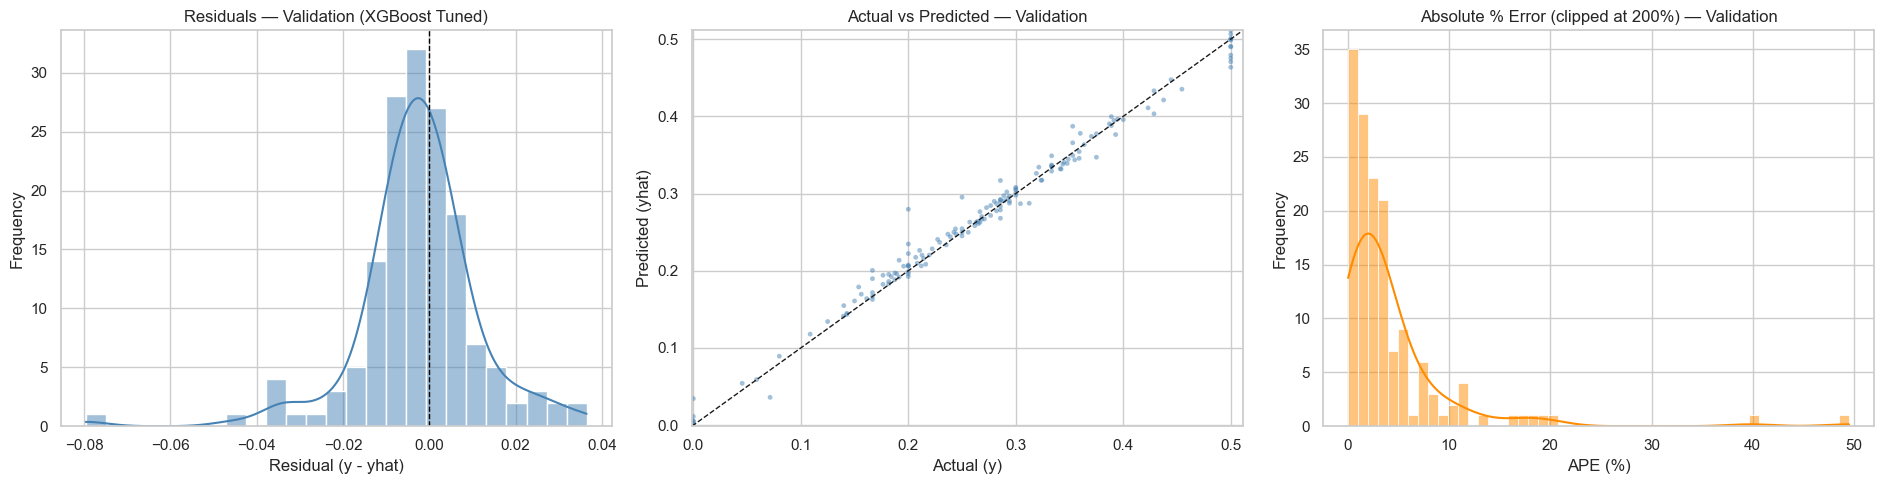

In [42]:
# Overall Error Distribution — Validation Set (prefers Tuned XGBoost, then Tuned LightGBM)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preconditions
if 'y_val' not in locals() or y_val is None or len(y_val) == 0:
    print("No validation set available.")
else:
    # Choose predictions in priority order
    model_used = None
    color = 'steelblue'
    y_pred = None

    if 'pred_val_xgb_tuned' in locals() and pred_val_xgb_tuned is not None:
        y_pred = np.array(pred_val_xgb_tuned)
        model_used = 'XGBoost Tuned'
        color = 'steelblue'
    elif 'best_xgb_model' in locals():
        y_pred = np.array(best_xgb_model.predict(X_val))
        model_used = 'XGBoost Tuned (recomputed)'
        color = 'steelblue'
    elif 'pred_val_tuned' in locals() and pred_val_tuned is not None:
        y_pred = np.array(pred_val_tuned)
        model_used = 'LightGBM Tuned'
        color = 'seagreen'
    elif 'best_lgb_model' in locals():
        y_pred = np.array(best_lgb_model.predict(X_val))
        model_used = 'LightGBM Tuned (recomputed)'
        color = 'seagreen'
    elif 'pred_val_xgb' in locals() and pred_val_xgb is not None:
        y_pred = np.array(pred_val_xgb)
        model_used = 'XGBoost Baseline'
        color = 'cornflowerblue'
    elif 'pred_val_lgb' in locals() and pred_val_lgb is not None:
        y_pred = np.array(pred_val_lgb)
        model_used = 'LightGBM Baseline'
        color = 'mediumseagreen'

    if y_pred is None:
        print("No validation predictions available to plot.")
    else:
        y_true = np.array(y_val)
        n = min(len(y_true), len(y_pred))
        y_true = y_true[:n]
        y_pred = y_pred[:n]

        df_err = pd.DataFrame({
            'y': y_true,
            'yhat': y_pred
        })
        df_err['residual'] = df_err['y'] - df_err['yhat']
        df_err['abs_error'] = df_err['residual'].abs()
        df_err['ape'] = np.where(df_err['y'] != 0,
                                 100 * (df_err['abs_error'] / np.abs(df_err['y'])),
                                 np.nan)

        # Metrics
        mae = df_err['abs_error'].mean()
        rmse = np.sqrt(np.mean(df_err['residual']**2))
        bias = df_err['residual'].mean()
        med_ape = np.nanmedian(df_err['ape'])
        smape_val = smape(y_true, y_pred) if 'smape' in globals() else np.nan

        print(f"Model: {model_used} | Samples: {n}")
        print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f} | Median APE: {med_ape:.2f}% | SMAPE: {smape_val:.2f}%")

        # Plots
        sns.set(style='whitegrid')
        fig, axes = plt.subplots(1, 3, figsize=(19, 5))

        # 1) Residuals distribution
        sns.histplot(df_err['residual'], bins='auto', kde=True, color=color, ax=axes[0])
        axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
        axes[0].set_title(f"Residuals — Validation ({model_used})")
        axes[0].set_xlabel("Residual (y - yhat)")
        axes[0].set_ylabel("Frequency")

        # 2) Actual vs Predicted scatter
        axes[1].scatter(df_err['y'], df_err['yhat'], s=12, alpha=0.5, color=color, edgecolor='none')
        lim_min = float(min(df_err['y'].min(), df_err['yhat'].min()))
        lim_max = float(max(df_err['y'].max(), df_err['yhat'].max()))
        axes[1].plot([lim_min, lim_max], [lim_min, lim_max], 'k--', linewidth=1)
        axes[1].set_xlim(lim_min, lim_max)
        axes[1].set_ylim(lim_min, lim_max)
        axes[1].set_title("Actual vs Predicted — Validation")
        axes[1].set_xlabel("Actual (y)")
        axes[1].set_ylabel("Predicted (yhat)")

        # 3) Absolute % Error (clipped for readability)
        ape_clip = df_err['ape'].clip(0, 200)
        sns.histplot(ape_clip.dropna(), bins=50, kde=True, color='darkorange', ax=axes[2])
        axes[2].set_title("Absolute % Error (clipped at 200%) — Validation")
        axes[2].set_xlabel("APE (%)")
        axes[2].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()